In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.transforms import Bbox


In [2]:
df = pd.read_csv("results_full.csv")

metric = "LogLoss"
df = df[df["metric"] == metric]
#df = df[df['suite_id'] == 336]

splits = [s for s in df["split_method"].unique() if s.lower() != "random_split"]
 
method_order = [
    'ConstantPredictor', 'LogisticRegressor' , 'RandomForestClassifier', 'RandomForestRegressor', 'LGBMClassifier', 'LGBMRegressor',
    'Engression', 'MLP', 'ResNet', 'FTTransformer', 'TabPFNClassifier', 'GPBoost_LogLoss', 'GPBoost_Accuracy', 'GPBoost_RMSE', 'GPBoost_CRPS'
]
rename_map = {
    'RandomForestClassifier': 'Random Forest',
    'RandomForestRegressor': 'Random Forest',
    'LGBMClassifier': 'Boosted Trees',
    'LGBMRegressor': 'Boosted Trees',
    'FTTransformer': 'FT-Transformer',
    'LogisticRegressor': 'Logistic Regression',
    'TabPFNCLassifier': 'TabPFN',
    'GPBoost_LogLoss': 'GPBoost'
}

# 3) Extract unique suites, metrics, and extrapolation methods
suites  = df['suite_id'].unique()
metrics = df['metric'].unique()
methods = df['split_method'].unique()

df = df[df["metric"] == "LogLoss"]
df = df[df["split_method"] == "random_split"]


=== RAW normalized_accuracy sample ===
     split_method  task_id                   model     value  baseline  \
0    random_split   361110         GPBoost_LogLoss  0.431736  0.330214   
9    random_split   361110       LogisticRegressor  0.511903  0.330214   
11   random_split   361110       ConstantPredictor  0.693167  0.330214   
25   random_split   361110              Engression  0.617910  0.330214   
26   random_split   361110                     MLP  0.420350  0.330214   
28   random_split   361110                  ResNet  0.427179  0.330214   
30   random_split   361110           FTTransformer  0.401918  0.330214   
57   random_split   361110        TabPFNClassifier  0.330214  0.330214   
65   random_split   361110  RandomForestClassifier  0.693147  0.330214   
67   random_split   361110          LGBMClassifier  0.693147  0.330214   
80   random_split   361111         GPBoost_LogLoss  0.664545  0.616384   
89   random_split   361111       LogisticRegressor  0.673534  0.616384  

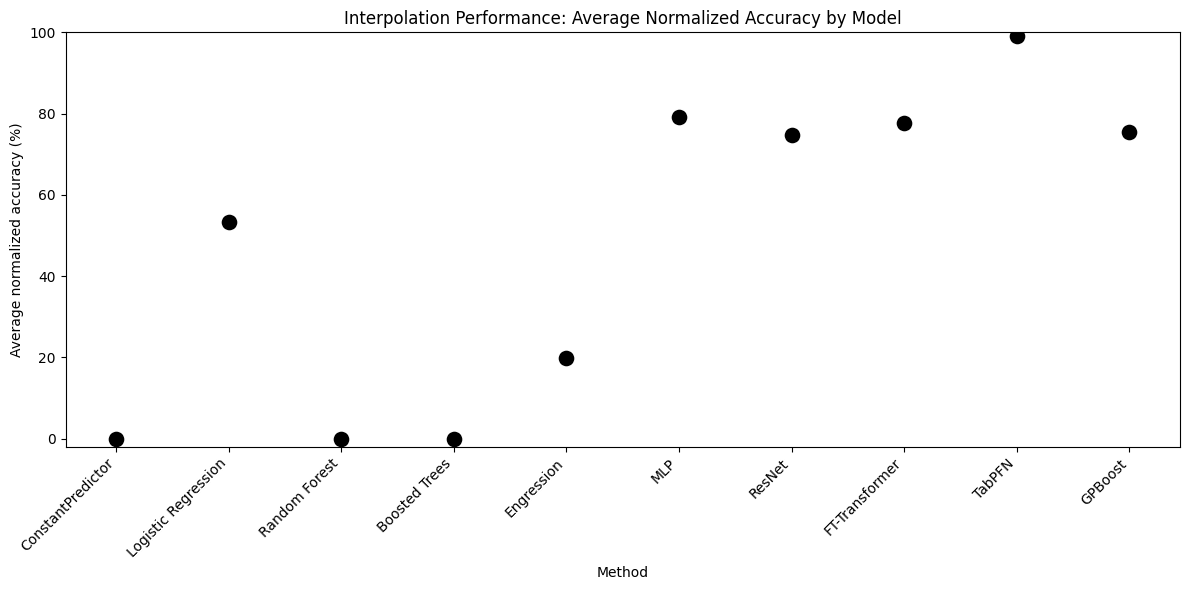

In [7]:
# helper to get the 3rd‐largest (or worst if <3)
def third_largest(s: pd.Series) -> float:
    vals = s.dropna().nlargest(3)
    return vals.min() if not vals.empty else np.nan

# 1) baseline (best = min error) per split & task
df["baseline"] = (
    df
    .groupby(["split_method", "task_id"])["value"]
    .transform("min")
)

# 2) mid (3rd‐largest error) per split & task
df["mid"] = (
    df
    .groupby(["split_method", "task_id"])["value"]
    .transform(third_largest)
)

# 3) normalized accuracy: (mid – err)/(mid – best), clipped into [0,1]
df["normalized_accuracy"] = (
    (df["mid"] - df["value"])
    / (df["mid"] - df["baseline"])
).clip(0, 1)

print("\n=== RAW normalized_accuracy sample ===")
print(df[['split_method','task_id','model','value','baseline','mid','normalized_accuracy']].head(20))

print("\n=== per-model normalized_accuracy summary ===")
print(
    df
    .groupby('model')["normalized_accuracy"]
    .agg(count='count', mean='mean', min='min', max='max')
    .sort_values('mean', ascending=False)
)

print("\n=== model appearance counts ===")
print(
    df
    .groupby('model')["normalized_accuracy"]
    .count()
    .sort_values(ascending=False)
)

overall = (
    df
    .groupby('model')["normalized_accuracy"]
    .mean()
    .reset_index(name='Mean')
)
overall['Mean'] *= 100   # to percent

method_order = [
    'ConstantPredictor','LogisticRegressor',
    'RandomForestClassifier','RandomForestRegressor',
    'LGBMClassifier','LGBMRegressor','Engression',
    'MLP','ResNet','FTTransformer','TabPFNClassifier', 'GPBoost_LogLoss']
overall = (
    overall
    .set_index('model')
    .reindex(method_order)
    .reset_index()
)
rename_map = {
    'RandomForestClassifier':'Random Forest',
    'RandomForestRegressor':'Random Forest',
    'LGBMClassifier':       'Boosted Trees',
    'LGBMRegressor':        'Boosted Trees',
    'FTTransformer':        'FT-Transformer',
    'LogisticRegressor':   'Logistic Regression',
    'TabPFNClassifier':     'TabPFN',
    'GPBoost_LogLoss':      'GPBoost'
}
overall['Method'] = overall['model'].map(rename_map).fillna(overall['model'])

plt.figure(figsize=(12,6))
sns.scatterplot(
    data=overall,
    x='Method',
    y='Mean',
    color='black',
    s=150
)
plt.xticks(rotation=45, ha='right')
plt.ylabel('Average normalized accuracy (%)')
plt.xlabel('Method')
plt.title('Interpolation Performance: Average Normalized Accuracy by Model')
plt.ylim(-2, 100)
plt.tight_layout()

os.makedirs('PICTURES', exist_ok=True)
fname = f"PICTURES/avg_normalized_acc_over_interpolation_{metric}.png"
plt.savefig(
    fname,
    bbox_inches='tight'
)
plt.show()
